In [1]:
from platform import python_version

print(python_version())

3.8.5


#### Import all libraries

In [2]:
# Data
import pandas as pd
import numpy as np
import os
import random
import re
import tqdm
import kaggle

# Preprocessing
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
import preprocessor as p

# Gensim LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Lemmatization
import spacy # python -m spacy download en_core_web_sm

# Plotting
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import preprocessor as p
from preprocessor.api import clean, tokenize, parse
nlp = spacy.load("en_core_web_sm")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import html
from textblob import TextBlob

nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
import pickle
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dcmabry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dcmabry/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dcmabry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-2-7f42ee9c90fb>:48: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


#### Obtain Tweets

In [4]:
# Download dataset
# Authentication https://www.kaggle.com/
# In order to use the Kaggle’s public API, you must first authenticate using an API token.
# From the site header, click on your user profile picture, then on “My Account” from the dropdown menu.
#v This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:
# To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.
# Save the token in your home directory, for Linux users ~/.kaggle/kaggle.json or C:\Users<Windows-username>.kaggle\kaggle.json on Windows
kaggle.api.authenticate()
kaggle.api.dataset_download_files('rapiddev/us-presidential-election-tweets-2020', path='.', unzip=True)

In [6]:
# Dataframe
df = pd.read_csv("tweets.csv")

#### Dataframe of Tweets

In [5]:
df.shape

(575000, 10)

In [6]:
df_tweets = df

#### Filter tweets for biden and trump hashtags

In [7]:
df_tweets["hashtags"]=[list(set(re.findall(r'(?i)\#\w+',str(tweet.lower()),flags=re.UNICODE))) for tweet in df_tweets.tweet] 

In [8]:
biden = ['#biden','#joebiden']
trump = ['#trump','#donaldtrump']
df_tweets_b = df_tweets[df_tweets.hashtags.map(lambda x: np.isin(x, biden).any())]
df_tweets_b['candidate_hashtag'] = 'biden'
df_tweets_t = df_tweets[df_tweets.hashtags.map(lambda x: np.isin(x, trump).any())]
df_tweets_t['candidate_hashtag'] = 'trump'
# df[df.Hashtags.map(lambda x: np.isin(x, candidates).all())]

<ipython-input-8-2cfaa3b04e2a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_b['candidate_hashtag'] = 'biden'
<ipython-input-8-2cfaa3b04e2a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_t['candidate_hashtag'] = 'trump'


In [9]:
###Number of Biden tweets

In [10]:
df_tweets_b.shape

(105265, 12)

In [11]:
###Number of Trump tweets

In [12]:
df_tweets_t.shape

(212531, 12)

In [13]:
####Concatenate dataframes and drop duplicates rows using _id

In [14]:
df_tweets = pd.concat([df_tweets_b, df_tweets_t]).drop_duplicates('_id').reset_index(drop=True)

In [15]:
df_tweets.shape

(296053, 12)

In [16]:
df_tweets = df_tweets.drop_duplicates(subset=['tweet'])

In [17]:
df_tweets.shape

(291984, 12)

#### Cleaning tweets: keeping emojis, capitalization, punctuation, Remove URL, Mentions (@), will not perform stemming or lemmatization
#####"A popular sentiment analysis method, VADER, has different ratings depending on the form of the word and therefore the input should not be stemmed or lemmatized."

In [18]:
p.set_options(p.OPT.URL,p.OPT.RESERVED,p.OPT.MENTION)

In [19]:
# Load stop words 
# stop_words = stopwords.words('english')
stop_words = []
stop_words +=['a','the','is','with','and','to','be','might','if','you']
# stop_words = set(stop_words)
stop_words

['a', 'the', 'is', 'with', 'and', 'to', 'be', 'might', 'if', 'you']

In [20]:
#Handling apostrophe
import re

def apostrophe_remover(text):
    
    text = re.sub(r"won’t", "will not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [21]:
tweet_clean = []
for tweet in df_tweets['tweet']:
    t = apostrophe_remover(tweet)
    t = p.clean(str(t)).replace(":",' ')
    t = p.clean(str(t)).replace("-",' ')
    t = p.clean(str(t)).replace("’",'')
    t = p.clean(str(t)).replace("#",'')
    t = p.clean(str(t)).replace("‘",'')
    t = p.clean(str(t)).replace(",",'')
    t1 = html.unescape(t)
    t1 = t1.split()
    t2 = [w for w in t1 if w not in stop_words]
#     t2 = [lmtzr.lemmatize(lmtzr.lemmatize(w,pos='v'),pos='n') for w in t1 if w not in stop_words]
    t3 = ' '.join(t2)
    tweet_clean.append(t3)


In [22]:
df_tweets['tweet_clean'] = [tweet for tweet in tweet_clean]

In [23]:
df_tweets = df_tweets.drop_duplicates(subset=['tweet_clean'])

In [24]:
df_tweets.shape

(263935, 13)

In [25]:
df_tweets

,_id,tweet,topic,created_at,retweet_count,favorite_count,location,coordinates,processed_dttm,_msgid,hashtags,candidate_hashtag,tweet_clean
0,5f84f41748abb2001038ef10,#trump is better than #Biden #ImOneHundredPercentSureThat,tweets/edwardst894,2020-10-13 00:25:51.000,NaN,NaN,"Tennessee, USA",NaN,2020-10-13 00:25:59.870,e42ef5c9.731c08,"[#biden, #imonehundredpercentsurethat, #trump]",biden,trump better than Biden ImOneHundredPercentSureThat
1,5f84f47148abb2001038ef17,"@MiamiHerald Things might be different if voters knew about the documented crimes of #Obama,#Biden,#Clinton&amp; #Kerry… https://t.co/XScBUSsMs0",tweets/Martico1285,2020-10-13 00:26:09.000,NaN,NaN,Australia,NaN,2020-10-13 00:27:29.892,8834f408.37e908,"[#biden, #kerry, #obama, #clinton]",biden,Things different voters knew about documented crimes of ObamaBidenClinton& Kerry…
2,5f84f48948abb2001038ef19,The VA was horrible under the #Obama and #Biden administration,tweets/TeufelHundenDog,2020-10-13 00:26:15.000,NaN,NaN,"Missouri, USA",NaN,2020-10-13 00:27:53.901,d34a9dab.8ae53,"[#biden, #obama]",biden,The VA was horrible under Obama Biden administration
3,5f84f4c548abb2001038ef21,#Biden #biden and #obama killed VETS! @DNC SAY NO to #JoeBiden,tweets/Audrey57659038,2020-10-13 00:26:33.000,NaN,NaN,NaN,NaN,2020-10-13 00:28:53.924,e3039c13.efb9e,"[#biden, #joebiden, #obama]",biden,Biden biden obama killed VETS! SAY NO JoeBiden
4,5f84f58548abb2001038ef30,"@MariannaNBCNews @JoeBiden Hey @MariannaNBCNews,\nCould you ask #Biden what he is talking about here? If there ARE p… https://t.co/8rxDeqNYhB",tweets/marykinva,2020-10-13 00:27:12.000,NaN,NaN,"Virginia, USA",NaN,2020-10-13 00:32:05.969,2981a8a2.9a3098,[#biden],biden,Hey Could ask Biden what he talking about here? If there ARE p…
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296048,5fa14d9e550b620011a7d180,@coachmikeb12 @rock_golf @PittsburghPG @mtgreenee @pgopinions So did #trump arrange for #RBG to die? It wash… https://t.co/tGzwSLN9Jf,tweets/stewbert,2020-11-03 10:27:24.000,NaN,NaN,Jamaica,NaN,2020-11-03 12:31:26.623,c5298fa7.d36e5,"[#rbg, #trump]",trump,So did trump arrange for RBG die? It wash…
296049,5fa14da5550b620011a7d182,Is it bad I actually think internationally the world is safer if #Trump wins this election. People are more cautiou… https://t.co/qXi8TXr0ZN,tweets/GND1989,2020-11-03 10:27:26.000,NaN,NaN,"Scotland, United Kingdom",NaN,2020-11-03 12:31:33.026,d4b5d900.4d55f8,[#trump],trump,Is it bad I actually think internationally world safer Trump wins this election. People are more cautiou…
296050,5fa14da5550b620011a7d183,#Trump does not want your #vote to #count.\nGo back to where you came from...,tweets/richardandjai,2020-11-03 10:27:27.000,NaN,NaN,NY,NaN,2020-11-03 12:31:33.827,86c804a8.71fa88,"[#count, #vote, #trump]",trump,Trump does not want your vote count. Go back where came from...
296051,5fa14db6550b620011a7d189,'A is for antisemitism': An alphabetical guide to #Trump's worst moments \n\nThis A-to-Z takes us from Trump's antise… https://t.co/Q4DsaNWb1o,tweets/DennisKoch10,2020-11-03 10:27:40.000,NaN,NaN,Edmonton Alberta,NaN,2020-11-03 12:31:50.632,674e88f3.a6d488,[#trump],trump,'A for antisemitism' An alphabetical guide Trump's worst moments This A Z takes us from Trump's antise…


### Sentiment Analysis

In [26]:
# sentiment analysis (positive, negative, neutral, compound)
pos = []
neg = []
neu = []
compound = []

# get sentiment scores for each review (original)
sid = SentimentIntensityAnalyzer()
for tweet in df_tweets['tweet_clean']:
    ss = sid.polarity_scores(tweet)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    compound.append(ss['compound'])

In [27]:
df_tweets['positive'] = pos
df_tweets['negative'] = neg
df_tweets['neutral'] = neu
df_tweets['compound'] = compound

In [28]:
df_tweets

,_id,tweet,topic,created_at,retweet_count,favorite_count,location,coordinates,processed_dttm,_msgid,hashtags,candidate_hashtag,tweet_clean,positive,negative,neutral,compound
0,5f84f41748abb2001038ef10,#trump is better than #Biden #ImOneHundredPercentSureThat,tweets/edwardst894,2020-10-13 00:25:51.000,NaN,NaN,"Tennessee, USA",NaN,2020-10-13 00:25:59.870,e42ef5c9.731c08,"[#biden, #imonehundredpercentsurethat, #trump]",biden,trump better than Biden ImOneHundredPercentSureThat,0.420,0.000,0.580,0.4404
1,5f84f47148abb2001038ef17,"@MiamiHerald Things might be different if voters knew about the documented crimes of #Obama,#Biden,#Clinton&amp; #Kerry… https://t.co/XScBUSsMs0",tweets/Martico1285,2020-10-13 00:26:09.000,NaN,NaN,Australia,NaN,2020-10-13 00:27:29.892,8834f408.37e908,"[#biden, #kerry, #obama, #clinton]",biden,Things different voters knew about documented crimes of ObamaBidenClinton& Kerry…,0.000,0.000,1.000,0.0000
2,5f84f48948abb2001038ef19,The VA was horrible under the #Obama and #Biden administration,tweets/TeufelHundenDog,2020-10-13 00:26:15.000,NaN,NaN,"Missouri, USA",NaN,2020-10-13 00:27:53.901,d34a9dab.8ae53,"[#biden, #obama]",biden,The VA was horrible under Obama Biden administration,0.000,0.333,0.667,-0.5423
3,5f84f4c548abb2001038ef21,#Biden #biden and #obama killed VETS! @DNC SAY NO to #JoeBiden,tweets/Audrey57659038,2020-10-13 00:26:33.000,NaN,NaN,NaN,NaN,2020-10-13 00:28:53.924,e3039c13.efb9e,"[#biden, #joebiden, #obama]",biden,Biden biden obama killed VETS! SAY NO JoeBiden,0.000,0.563,0.437,-0.8283
4,5f84f58548abb2001038ef30,"@MariannaNBCNews @JoeBiden Hey @MariannaNBCNews,\nCould you ask #Biden what he is talking about here? If there ARE p… https://t.co/8rxDeqNYhB",tweets/marykinva,2020-10-13 00:27:12.000,NaN,NaN,"Virginia, USA",NaN,2020-10-13 00:32:05.969,2981a8a2.9a3098,[#biden],biden,Hey Could ask Biden what he talking about here? If there ARE p…,0.000,0.000,1.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296048,5fa14d9e550b620011a7d180,@coachmikeb12 @rock_golf @PittsburghPG @mtgreenee @pgopinions So did #trump arrange for #RBG to die? It wash… https://t.co/tGzwSLN9Jf,tweets/stewbert,2020-11-03 10:27:24.000,NaN,NaN,Jamaica,NaN,2020-11-03 12:31:26.623,c5298fa7.d36e5,"[#rbg, #trump]",trump,So did trump arrange for RBG die? It wash…,0.000,0.328,0.672,-0.5994
296049,5fa14da5550b620011a7d182,Is it bad I actually think internationally the world is safer if #Trump wins this election. People are more cautiou… https://t.co/qXi8TXr0ZN,tweets/GND1989,2020-11-03 10:27:26.000,NaN,NaN,"Scotland, United Kingdom",NaN,2020-11-03 12:31:33.026,d4b5d900.4d55f8,[#trump],trump,Is it bad I actually think internationally world safer Trump wins this election. People are more cautiou…,0.283,0.152,0.565,0.4588
296050,5fa14da5550b620011a7d183,#Trump does not want your #vote to #count.\nGo back to where you came from...,tweets/richardandjai,2020-11-03 10:27:27.000,NaN,NaN,NY,NaN,2020-11-03 12:31:33.827,86c804a8.71fa88,"[#count, #vote, #trump]",trump,Trump does not want your vote count. Go back where came from...,0.000,0.100,0.900,-0.0572
296051,5fa14db6550b620011a7d189,'A is for antisemitism': An alphabetical guide to #Trump's worst moments \n\nThis A-to-Z takes us from Trump's antise… https://t.co/Q4DsaNWb1o,tweets/DennisKoch10,2020-11-03 10:27:40.000,NaN,NaN,Edmonton Alberta,NaN,2020-11-03 12:31:50.632,674e88f3.a6d488,[#trump],trump,'A for antisemitism' An alphabetical guide Trump's worst moments This A Z takes us from Trump's antise…,0.000,0.227,0.773,-0.6249


In [29]:
df_tweets.iloc[164692] 

_id                  5f910f3427d0bb00172b1851                                                        
tweet                Goggle #moron. \nWhat a surprise...🤣🤣🤣\n#Trump comes up. https://t.co/SW1GTBETPE
topic                tweets/really_beck                                                              
created_at           2020-10-22 02:30:22.000                                                         
retweet_count        NaN                                                                             
favorite_count       NaN                                                                             
location             NaN                                                                             
coordinates          NaN                                                                             
processed_dttm       2020-10-22 04:48:52.067                                                         
_msgid               86195df7.fccd                                                

In [30]:
df_tweets.iloc[164736] 

_id                  5f91117b27d0bb00172b18e4                                                                                                                   
tweet                In walking out on the #EU and parroting #Trump's belligerent rhetoric on #China, #Brexit has effectively alienated… https://t.co/9trxqubDF6
topic                tweets/medjak40                                                                                                                            
created_at           2020-10-22 02:35:30.000                                                                                                                    
retweet_count        NaN                                                                                                                                        
favorite_count       NaN                                                                                                                                        
location             Australia    

#### Distribution of compound scores

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

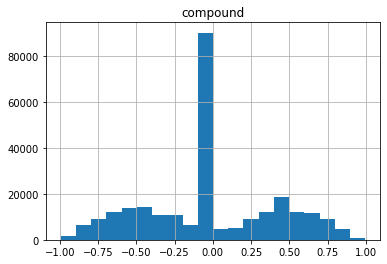

In [31]:
df_tweets.hist(column="compound",bins=20)

In [32]:
conditions = [
    df_tweets['compound'] >= .30,
    df_tweets['compound'] <= -.30,
    df_tweets['compound'] == 0
]
outcomes = ['positive','negative','unknown']

df_tweets['sentiment'] = np.select(conditions,outcomes,default='neutral')

In [33]:
df_tweets = df_tweets[df_tweets.sentiment.str.contains('positive|negative|neutral')]

In [34]:
df_tweets.shape

(177790, 18)

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

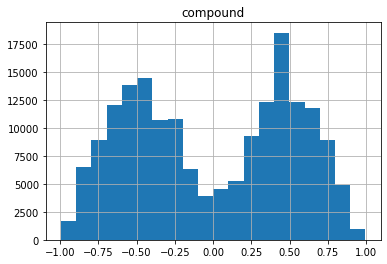

In [35]:
df_tweets.hist(column="compound",bins=20)

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

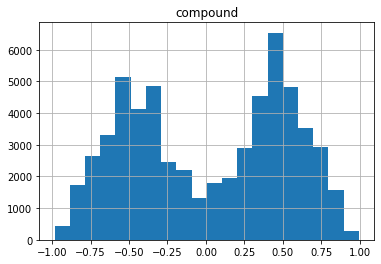

In [36]:
df_tweets[df_tweets.candidate_hashtag=='biden'].hist(column="compound",bins=20)

array([[<AxesSubplot:title={'center':'compound'}>]], dtype=object)

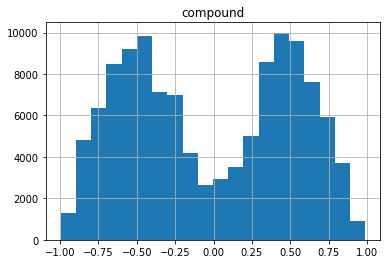

In [37]:
df_tweets[df_tweets.candidate_hashtag=='trump'].hist(column="compound",bins=20)

In [38]:
df_tweets[df_tweets.candidate_hashtag=='biden'].shape

(59056, 18)

In [39]:
df_tweets[df_tweets.candidate_hashtag=='trump'].shape

(118734, 18)

In [40]:
df_tweets.shape

(177790, 18)

In [41]:
t = df_tweets.drop_duplicates(subset=['topic','positive','negative','neutral','compound'])

In [42]:
t.shape

(171548, 18)

In [43]:
t

,_id,tweet,topic,created_at,retweet_count,favorite_count,location,coordinates,processed_dttm,_msgid,hashtags,candidate_hashtag,tweet_clean,positive,negative,neutral,compound,sentiment
0,5f84f41748abb2001038ef10,#trump is better than #Biden #ImOneHundredPercentSureThat,tweets/edwardst894,2020-10-13 00:25:51.000,NaN,NaN,"Tennessee, USA",NaN,2020-10-13 00:25:59.870,e42ef5c9.731c08,"[#biden, #imonehundredpercentsurethat, #trump]",biden,trump better than Biden ImOneHundredPercentSureThat,0.420,0.000,0.580,0.4404,positive
2,5f84f48948abb2001038ef19,The VA was horrible under the #Obama and #Biden administration,tweets/TeufelHundenDog,2020-10-13 00:26:15.000,NaN,NaN,"Missouri, USA",NaN,2020-10-13 00:27:53.901,d34a9dab.8ae53,"[#biden, #obama]",biden,The VA was horrible under Obama Biden administration,0.000,0.333,0.667,-0.5423,negative
3,5f84f4c548abb2001038ef21,#Biden #biden and #obama killed VETS! @DNC SAY NO to #JoeBiden,tweets/Audrey57659038,2020-10-13 00:26:33.000,NaN,NaN,NaN,NaN,2020-10-13 00:28:53.924,e3039c13.efb9e,"[#biden, #joebiden, #obama]",biden,Biden biden obama killed VETS! SAY NO JoeBiden,0.000,0.563,0.437,-0.8283,negative
5,5f84f60c48abb2001038ef3f,Too Funny! #Biden #Democrats #Patriot #Trump,tweets/dmerk61,2020-10-13 00:27:43.000,NaN,NaN,"Lexington KY, USA",NaN,2020-10-13 00:34:20.999,fb802868.5bed98,"[#biden, #democrats, #patriot, #trump]",biden,Too Funny! Biden Democrats Patriot Trump,0.390,0.000,0.610,0.4926,positive
8,5f84f73648abb2001038ef58,They’ve scared you! Caused you to be angry with and to hate President #Trump! Imagine if you vote for Joe #Biden:\n-… https://t.co/wJ4dfulhpf,tweets/revrmoody,2020-10-13 00:28:54.000,NaN,NaN,Missouri,NaN,2020-10-13 00:39:18.061,9db227e1.0cc4b8,"[#biden, #trump]",biden,They have scared you! Caused angry hate President Trump! Imagine vote for Joe Biden …,0.000,0.488,0.512,-0.8881,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296046,5fa14d8b550b620011a7d178,@MSNBC Old News! Who doesn’t #tRUmp lash out at? He nuts✌️🦉Vote #BidenHarris2020 to Save America &amp; Democracy,tweets/wannabesnowbird,2020-11-03 10:27:16.000,NaN,NaN,NaN,NaN,2020-11-03 12:31:07.413,a9785e1a.56058,"[#bidenharris2020, #trump]",trump,Old News! Who does not tRUmp lash out at? He nuts✌️🦉Vote BidenHarris2020 Save America & Democracy,0.200,0.000,0.800,0.5411,positive
296048,5fa14d9e550b620011a7d180,@coachmikeb12 @rock_golf @PittsburghPG @mtgreenee @pgopinions So did #trump arrange for #RBG to die? It wash… https://t.co/tGzwSLN9Jf,tweets/stewbert,2020-11-03 10:27:24.000,NaN,NaN,Jamaica,NaN,2020-11-03 12:31:26.623,c5298fa7.d36e5,"[#rbg, #trump]",trump,So did trump arrange for RBG die? It wash…,0.000,0.328,0.672,-0.5994,negative
296049,5fa14da5550b620011a7d182,Is it bad I actually think internationally the world is safer if #Trump wins this election. People are more cautiou… https://t.co/qXi8TXr0ZN,tweets/GND1989,2020-11-03 10:27:26.000,NaN,NaN,"Scotland, United Kingdom",NaN,2020-11-03 12:31:33.026,d4b5d900.4d55f8,[#trump],trump,Is it bad I actually think internationally world safer Trump wins this election. People are more cautiou…,0.283,0.152,0.565,0.4588,positive
296051,5fa14db6550b620011a7d189,'A is for antisemitism': An alphabetical guide to #Trump's worst moments \n\nThis A-to-Z takes us from Trump's antise… https://t.co/Q4DsaNWb1o,tweets/DennisKoch10,2020-11-03 10:27:40.000,NaN,NaN,Edmonton Alberta,NaN,2020-11-03 12:31:50.632,674e88f3.a6d488,[#trump],trump,'A for antisemitism' An alphabetical guide Trump's worst moments This A Z takes us from Trump's antise…,0.000,0.227,0.773,-0.6249,negative


In [44]:
### Storing dataframe into pickle file and excel

In [45]:
t.to_pickle("sentiment_df.pkl")

In [46]:
final_unpickled = pd.read_pickle("sentiment_df.pkl")

In [47]:
final_unpickled

,_id,tweet,topic,created_at,retweet_count,favorite_count,location,coordinates,processed_dttm,_msgid,hashtags,candidate_hashtag,tweet_clean,positive,negative,neutral,compound,sentiment
0,5f84f41748abb2001038ef10,#trump is better than #Biden #ImOneHundredPercentSureThat,tweets/edwardst894,2020-10-13 00:25:51.000,NaN,NaN,"Tennessee, USA",NaN,2020-10-13 00:25:59.870,e42ef5c9.731c08,"[#biden, #imonehundredpercentsurethat, #trump]",biden,trump better than Biden ImOneHundredPercentSureThat,0.420,0.000,0.580,0.4404,positive
2,5f84f48948abb2001038ef19,The VA was horrible under the #Obama and #Biden administration,tweets/TeufelHundenDog,2020-10-13 00:26:15.000,NaN,NaN,"Missouri, USA",NaN,2020-10-13 00:27:53.901,d34a9dab.8ae53,"[#biden, #obama]",biden,The VA was horrible under Obama Biden administration,0.000,0.333,0.667,-0.5423,negative
3,5f84f4c548abb2001038ef21,#Biden #biden and #obama killed VETS! @DNC SAY NO to #JoeBiden,tweets/Audrey57659038,2020-10-13 00:26:33.000,NaN,NaN,NaN,NaN,2020-10-13 00:28:53.924,e3039c13.efb9e,"[#biden, #joebiden, #obama]",biden,Biden biden obama killed VETS! SAY NO JoeBiden,0.000,0.563,0.437,-0.8283,negative
5,5f84f60c48abb2001038ef3f,Too Funny! #Biden #Democrats #Patriot #Trump,tweets/dmerk61,2020-10-13 00:27:43.000,NaN,NaN,"Lexington KY, USA",NaN,2020-10-13 00:34:20.999,fb802868.5bed98,"[#biden, #democrats, #patriot, #trump]",biden,Too Funny! Biden Democrats Patriot Trump,0.390,0.000,0.610,0.4926,positive
8,5f84f73648abb2001038ef58,They’ve scared you! Caused you to be angry with and to hate President #Trump! Imagine if you vote for Joe #Biden:\n-… https://t.co/wJ4dfulhpf,tweets/revrmoody,2020-10-13 00:28:54.000,NaN,NaN,Missouri,NaN,2020-10-13 00:39:18.061,9db227e1.0cc4b8,"[#biden, #trump]",biden,They have scared you! Caused angry hate President Trump! Imagine vote for Joe Biden …,0.000,0.488,0.512,-0.8881,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296046,5fa14d8b550b620011a7d178,@MSNBC Old News! Who doesn’t #tRUmp lash out at? He nuts✌️🦉Vote #BidenHarris2020 to Save America &amp; Democracy,tweets/wannabesnowbird,2020-11-03 10:27:16.000,NaN,NaN,NaN,NaN,2020-11-03 12:31:07.413,a9785e1a.56058,"[#bidenharris2020, #trump]",trump,Old News! Who does not tRUmp lash out at? He nuts✌️🦉Vote BidenHarris2020 Save America & Democracy,0.200,0.000,0.800,0.5411,positive
296048,5fa14d9e550b620011a7d180,@coachmikeb12 @rock_golf @PittsburghPG @mtgreenee @pgopinions So did #trump arrange for #RBG to die? It wash… https://t.co/tGzwSLN9Jf,tweets/stewbert,2020-11-03 10:27:24.000,NaN,NaN,Jamaica,NaN,2020-11-03 12:31:26.623,c5298fa7.d36e5,"[#rbg, #trump]",trump,So did trump arrange for RBG die? It wash…,0.000,0.328,0.672,-0.5994,negative
296049,5fa14da5550b620011a7d182,Is it bad I actually think internationally the world is safer if #Trump wins this election. People are more cautiou… https://t.co/qXi8TXr0ZN,tweets/GND1989,2020-11-03 10:27:26.000,NaN,NaN,"Scotland, United Kingdom",NaN,2020-11-03 12:31:33.026,d4b5d900.4d55f8,[#trump],trump,Is it bad I actually think internationally world safer Trump wins this election. People are more cautiou…,0.283,0.152,0.565,0.4588,positive
296051,5fa14db6550b620011a7d189,'A is for antisemitism': An alphabetical guide to #Trump's worst moments \n\nThis A-to-Z takes us from Trump's antise… https://t.co/Q4DsaNWb1o,tweets/DennisKoch10,2020-11-03 10:27:40.000,NaN,NaN,Edmonton Alberta,NaN,2020-11-03 12:31:50.632,674e88f3.a6d488,[#trump],trump,'A for antisemitism' An alphabetical guide Trump's worst moments This A Z takes us from Trump's antise…,0.000,0.227,0.773,-0.6249,negative


In [48]:
t.to_excel("sentiment_df.xlsx") 

In [49]:
sid.polarity_scores("crimes")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}